# Computational Exercise 6: Better MNIST Predictions with Tensorflow

**Please note that (optionally) this assignment may be completed in groups of 2 students.**

---
In this exercise, we'll take a look at an important limitation of logistic regression and MLP models applied to images, then overcome these limitations by training a shallow CNN in Tensorflow.

Goals are as follows:

- Observe that logistic regression is *not* effective when digits are not centered (why?)
- Train a simple CNN to identify digits *even when their position varies*
- Visualize the filters for each digit learned by the CNN
- Create and train a model that classifies handwritten digits with over 98% accuracy

We'll begin by importing required libraries:

- numpy for efficient math operations
- sklearn for defining and training our logistic regression and MLP models
- tensorflow for defining and training our simple CNN
- matplotlib for visualization/plotting

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

As before, we'll load the MNIST dataset. The data are already broken down into:

1. a development set, which we'll use for training
2. a test set, which we'll use to evaluate performance

As in the previous exercise, we will not be tuning our models, so we will not set aside a validation set.

In [2]:
# Load MNIST
(x_dev, y_dev), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('There are', len(x_dev), 'training images.')
print('There are', len(x_test), 'test images.')

There are 60000 training images.
There are 10000 test images.


To review code that allows us to inspect the images and labels, please review [Computational Exercise 5](https://github.com/mengelhard/bsrt_ml4h/blob/master/notebooks/ce5.ipynb).

## Un-Centering our Digits
In MNIST, all digits are centered, which substantially simplifies the problem. In many real-world datasets, on the other hand, we need to identify image features regardless of where they may be present within the image. Let's explore this issue by modifying MNIST so that digits are no longer centered. We'll first enlarge the images, then place digits at random positions within the enlarged image. We'll do this by padding each image (in both our development and test sets) with zeroes.

In [3]:
def pad_image(img, pad_len):
    m, n = img.shape
    i = np.random.randint(pad_len - 2) + 1 # pick a horizontal offset between 1 and (pad_len - 1)
    j = np.random.randint(pad_len - 2) + 1 # pick a vertical offset bewteen 1 and (pad_len - 1)
    img = np.concatenate([[[0] * i] * m, img, [[0] * (pad_len - i)] * m], axis=1) # pad horizontally
    img = np.concatenate([[[0] * (n + pad_len)] * j, img, [[0] * (n + pad_len)] * (pad_len - j)], axis=0) # pad vertically
    return img

x_dev_padded = np.array([pad_image(x, 20) for x in x_dev])
x_test_padded = np.array([pad_image(x, 20) for x in x_test])

In the plots below, we see that digits are no longer centered in the modified dataset.

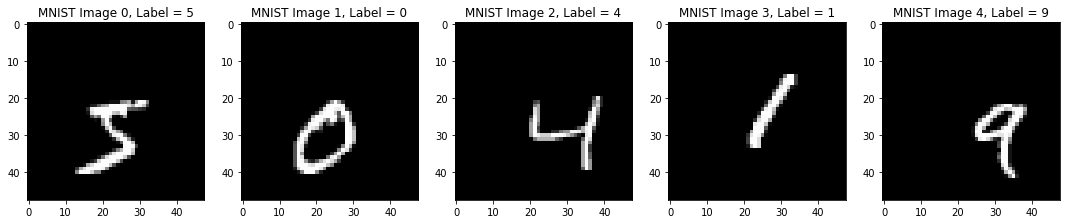

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(x_dev_padded[i, :, :], cmap='gray')
    ax[i].set_title('MNIST Image %i, Label = %i' % (i, y_dev[i]), fontsize=12)
plt.tight_layout()
plt.show()

## Exercise 1: Logistic Regression
Let's see whether logistic regression is able to classify digits effectively now that they're not centered. In the following block, you should:
- Train a logistic regression model (i.e. LogisticRegression()) to predict the labels of digits in MNIST.
- After training a model on the development set, evaluate its accuracy on the test set. As in the previous computational excercise, you'll need to flatten the images in order to use logistic regression. Remember that your predictions are no longer binary; instead, you are predicting one of ten different digits.
- visualize the logistic regression filters using the same or similar code as in [computational exercise 5](https://github.com/mengelhard/bsrt_ml4h/blob/master/notebooks/ce5.ipynb).

In [12]:
from sklearn.linear_model import LogisticRegression

### CREATE A LOGISTIC REGRESSION MODEL AND TRAIN IT ON THE FLATTENED DEVELOPMENT SET ###


### USE THE TRAINED MODEL TO MAKE PREDICTIONS ON THE (FLATTENED) TEST SET ###


### EVALUATE THE ACCURACY OF THE MODEL'S PREDICTIONS ON THE TEST SET ###

In [13]:
### ACCESS THE MODEL COEFFICIENTS ###


### RESHAPE EACH OF THE 10 COEFFICIENT VECTORS TO HAVE SHAPE (28, 28) ###


### PLOT EACH OF THE RESHAPED VECTORS (i.e. FILTERS) ###

## Our First Tensorflow Model

Let's see if a CNN can do better. In the code below, we'll define and train a very simple CNN that follows an example from our lectures. Specifically, we'll use 10 filters, one for each digit, each of size 28 x 28 -- the same size as the unmodified MNIST images.

Note that this CNN is both unusual and inefficient -- normally, CNNs use a larger number of much smaller filters -- but it will allow us to see the *translation invariance* of the CNN.

After applying our convolutional layer with unusually large filters, we'll max pool the output of each filter across the whole image, which should tell us whether the digit corresponding to that filter is present *anywhere* within the image. The output of the pooling operations will give us the predicted log-odds for each of the 10 digits.

We'll begin by converting our dataset into a tensorflow Dataset object. This accomplishes two things. First, it converts our `numpy` arrays into tensors that we can pass to a Tensorflow model. Second, it will split our test and training datasets into smaller chunks, called batches, that we can iterate over during training and testing. In this case, we'll use batches of size 32, meaning that our Tensorflow model will be processing 32 images at a time.

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_dev_padded.astype('float32'), y_dev)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_padded.astype('float32'), y_test)).batch(32)

We can then loop over our batches as shown in the next block. Here our goal is just to see what a single batch looks like, so we'll break the loop after printing out the first batch.

In [6]:
for images, labels in enumerate(train_ds):
    print(images)
    print(labels)
    break

0
(<tf.Tensor: shape=(32, 48, 48), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

## Defining the Model

Now it's time to define our model. We'll begin by importing the different types of layers we'll need, including:
1. Dense layers, i.e. fully connected layers. By default, there is no activation function in these layers, but we can specify one (e.g. sigmoid) with the `activation` argument.
2. Conv2D layers, i.e. convolutional layers. The first two arguments when defining such a layer are the number and size of the filters, respectively.
3. MaxPool2D layers, i.e. max pooling layers. The first argument specifies the size (i.e. width and length) of the pooling window.
4. Flatten layers simply flatten the tensor similar to `.flatten` in `numpy`.

We can then import the Tensorflow `Model` class, which provides a foundation for the model we'll be defining.

In the code below, we'll define our new, `SimpleCNN` class based on the model class. Really understanding what's happening here requires you to understand a little bit about classes in Python. Ultimately, though, there are a few important things to note.

- You'll follow this general template every time you build your own Tensorflow model.
- Each of the layers in your model will be defined in the `__init__` method. Here we'll define a single Conv2D layer called `conv1`, a single MaxPool2D layer called `mp1`, and a single Flatten layer called `flatten`. Prefacing these new layers with `self.` (e.g. `self.conv1`) specifies that they are attributes of the model; in other words, they are *attached* to the model much like `.coef_` was an attribute of LogisticRegression.
- The `call` method then defines how the layers are successively applied to transform input into hidden (i.e. latent variables) and eventually into predictions. Here we first add a new axis to the input; this is needed because `Conv2D` expects a `channels` axis (e.g. RGB color channels). We then apply our convolutional layer, followed by our max-pool layer, and finally we flatten everything, resulting in a vector of 10 different log-odds values corresponding to our 10 digits.

In [7]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Model

class SimpleCNN(Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = Conv2D(10, 28, use_bias=False)
        self.mp1 = MaxPool2D(21)
        self.flatten = Flatten()

    def call(self, x):
        x = x[..., tf.newaxis]
        x = self.conv1(x)
        x = self.mp1(x)
        return self.flatten(x)

We can then create an instance of our `SimpleCNN`, just as we did when using `LogisticRegression` or `MLPClassifier` in `sklearn`.

In [8]:
model = SimpleCNN()

There's one more step, and then we can start training the model.
- First, we'll define a `loss_object` that will make it easy for us to calculate the cross-entropy loss based on (a) the model-predicted logits, and (b) the true labels in our training set.
- Then, we'll need to define an optimizer that will determine exactly how our model's parameters should be altered based on the gradient of the loss, which Tensorflow will calculate automatically using `loss_object`.

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # multi-class cross-entropy loss
optimizer = tf.keras.optimizers.Adam() # modified stochastic gradient descent optimizer

We're now ready to train. We'll loop over all the batches in our training set 3 times in a row (i.e. 3 EPOCHS). For each batch, we'll:
1. apply our model to generate predictions for that batch
2. calculate the loss based on those predictions
3. calculate the gradient of the loss (i.e. how much does loss change in respose to changes in each parameter)
4. use our optimizer to adjust the model parameters (i.e. `model.trainable_variables`) based on the gradient.
- Note that `tf.GradientTape()` is just a quirk of Tensorflow that tells Tensorflow to watch the model parameters as it calculates the loss.

**Important**: This code will be very slow unless you switch to a GPU runtime from the Colab menu. Even with this change, it'll still take a minute or two.
- Runtime > Change runtime type

In [10]:
EPOCHS = 3

for epoch in range(EPOCHS):
  
    for images, labels in train_ds:
    
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    print('Completed epoch', epoch)

Completed epoch 0
Completed epoch 1
Completed epoch 2


Having trained our model, we can now evaluate its accuracy on the training set. This is very similar to code we've used before, but here we're calculating accuracy batch by batch, then averaging the results.

In [11]:
accuracy = []

for images, labels in test_ds:
    
    predicted_logits = model(images)
    predicted_labels = np.argmax(predicted_logits, axis=1)
    
    batch_accuracy = np.mean(predicted_labels == labels)
    accuracy.append(batch_accuracy)

accuracy = np.mean(accuracy)
print('The accuracy is %.3f' % accuracy)

The accuracy is 0.931


## Exercise 2: Visualize the filters learned by the CNN
The filters of the trained model can be accessed as an attribute of the `model.conv1` layer, as shown in the first line of the block below. `filters` will be an array of size (10, 28, 28) corresponding to the 10 filters -- one for each digit -- each of which is the same size (28 by 28) as the images. In the following block, you should plot and inspect these filters.

In [55]:
filters = np.moveaxis(np.squeeze(model.conv1.get_weights()[0]), [0, 1, 2], [1, 2, 0])

### PLOT EACH OF THE 10 28 by 28 FILTERS ###



## Exercise 3: A better CNN.

The CNN we defined was interesting, but it's not very efficient. In short, 28 by 28 filters are too big, and although this architecture is good for illustrating translation invariance, its accuracy can be improved.

In this exercise, you'll build a better CNN, train it, and evaluate it.
- Create the model by following the prompts in the code block below.
- Then, duplicate code blocks above to create an instance of `BetterCNN`, train it, and evaluate its performance on the test set.

The following may also be interesting, though none is required:
- visualize the learned filters in the convolutional layer
- modify the architecture to see if performance can be further improved

In [ ]:
class BetterCNN(Model):
    def __init__(self):
        super(BetterCNN, self).__init__()
        ### DEFINE A CONVOLUTIONAL LAYER WITH 32 FILTERS OF SIZE 3 (i.e. 3x3) AND RELU ACTIVATION (i.e. activation='relu') ###
        ### DEFINE A FLATTEN LAYER ###
        ### DEFINE A DENSE LAYER WITH OUTPUT SIZE 128 AND RELU ACTIVATION (i.e. activation='relu') ###
        ### DEFINE A DENSE LAYER WITH OUTPUT SIZE 10 AND NO ACTIVATION. THIS IS THE FINAL LAYER; OUTPUT WILL BE THE LOG-ODDS ###

    def call(self, x):
        x = x[..., tf.newaxis]
        #x = ### APPLY CONVOLUTIONAL LAYER ###
        #x = ### APPLY FLATTEN LAYER ###
        #x = ### APPLY FIRST DENSE LAYER ###
        #x = ### APPLY SECOND DENSE LAYER ###
        return x

The following blocks, repeated from above, can now be used to train and evaluate `BetterCNN`.

In [ ]:
model = BetterCNN()

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  
    for images, labels in train_ds:
    
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    print('Completed epoch', epoch)

In [ ]:
accuracy = []

for images, labels in test_ds:
    
    predicted_logits = model(images)
    predicted_labels = np.argmax(predicted_logits, axis=1)
    
    batch_accuracy = np.mean(predicted_labels == labels)
    accuracy.append(batch_accuracy)

accuracy = np.mean(accuracy)
print('The accuracy is %.3f' % accuracy)

### Once you've completed these exercises, please turn in the assignment as follows:

If you're using Anaconda on your local machine:
- download your notebook as html (see File > Download as > HTML (.html))
- .zip the file (i.e. place it in a .zip archive)
- submit the .zip file in Talent LMS

If you're using Google Colab:
- download your notebook as .ipynb (see File > Download > Download .ipynb)
- if you have nbconvert installed, convert it to .html; if not, leave is as .ipynb
- .zip the file (i.e. place it in a .zip archive)
- submit the .zip file in Talent LMS